[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/class_02.ipynb)

# 本日の内容

## 目次
1. 過学習について
1. パラメータの数え方
1. モデルの軽量化
  - 量子化
  - 枝刈り
1. オートエンコーダについて
1. テーマの割り当て

## 1. 過学習について

### 1-0.ライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

### 1-1.データセットの作成

In [ ]:
# 普通のtransform (変更可能)
transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# テストデータには普通のtransformを使ってください
transform_for_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normal)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_for_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### 1-2.モデルの作成

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self): # モデルのセットアップ
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x): # モデルが行う処理
        x = x.view(-1, 28 * 28)  # 28x28の画像を１次元に変換
        x = self.fc1(x) # ベクトルサイズを28x28から128へ
        x = nn.ReLU()(x) # 活性化関数
        x = self.fc2(x) # ベクトルサイズを128から128へ
        x = nn.ReLU()(x) # 活性化関数
        x = self.fc3(x) # ベクトルサイズを128から10へ
        return x

# モデルのインスタンスを作成
model = SimpleModel()

### 1-3. 損失関数, 最適化関数の定義

In [ ]:
criterion = nn.CrossEntropyLoss()
# 変更可能
optimizer = optim.SGD(model.parameters(), lr=0.1)

### 1-4. モデルの学習

モデルを30エポック訓練します。  
各エポックでの訓練損失, テスト損失, 訓練精度, テスト精度を取得します。

In [ ]:
# エポック数
epochs = 30

# 訓練とテストの損失・精度を記録するリスト
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # 訓練フェーズ
    model.train()  # 訓練モード
    loss_sum = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # モデルの予測
        outputs = model(images)
        # 損失の計算
        loss = criterion(outputs, labels)
        loss_sum += loss.item()
        # 勾配の初期化
        optimizer.zero_grad()
        # バックプロパゲーション
        loss.backward()
        # オプティマイザの更新
        optimizer.step()
        # 精度の計算
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # 訓練損失と訓練精度
    avg_train_loss = loss_sum / len(train_loader)
    train_loss = avg_train_loss
    train_accuracy = 100 * correct_train / total_train

    # テストフェーズ
    model.eval()  # 評価モード
    loss_sum_test = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum_test += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # テスト損失とテスト精度
    avg_test_loss = loss_sum_test / len(test_loader)
    test_loss = avg_test_loss
    test_accuracy = 100 * correct_test / total_test

    # 訓練とテストの損失・精度をリストに保存
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # 損失と精度を表示
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/30]
Train Loss: 0.4367, Train Accuracy: 86.03%
Test Loss: 0.3832, Test Accuracy: 87.52%
Epoch [2/30]
Train Loss: 0.1705, Train Accuracy: 94.74%
Test Loss: 0.1630, Test Accuracy: 94.77%
Epoch [3/30]
Train Loss: 0.1241, Train Accuracy: 96.19%
Test Loss: 0.1234, Test Accuracy: 95.99%
Epoch [4/30]
Train Loss: 0.0997, Train Accuracy: 96.95%
Test Loss: 0.0964, Test Accuracy: 97.07%
Epoch [5/30]
Train Loss: 0.0823, Train Accuracy: 97.46%
Test Loss: 0.1159, Test Accuracy: 96.28%
Epoch [6/30]
Train Loss: 0.0711, Train Accuracy: 97.80%
Test Loss: 0.1782, Test Accuracy: 94.35%
Epoch [7/30]
Train Loss: 0.0610, Train Accuracy: 98.14%
Test Loss: 0.0934, Test Accuracy: 96.99%
Epoch [8/30]
Train Loss: 0.0543, Train Accuracy: 98.22%
Test Loss: 0.0837, Test Accuracy: 97.53%
Epoch [9/30]
Train Loss: 0.0470, Train Accuracy: 98.51%
Test Loss: 0.0959, Test Accuracy: 97.12%
Epoch [10/30]
Train Loss: 0.0423, Train Accuracy: 98.69%
Test Loss: 0.0850, Test Accuracy: 97.29%
Epoch [11/30]
Train Loss: 0.0

### 1-5. 過学習について

以下のセルは各エポックでの訓練損失, テスト損失, 訓練精度, テスト精度をプロットするものです。

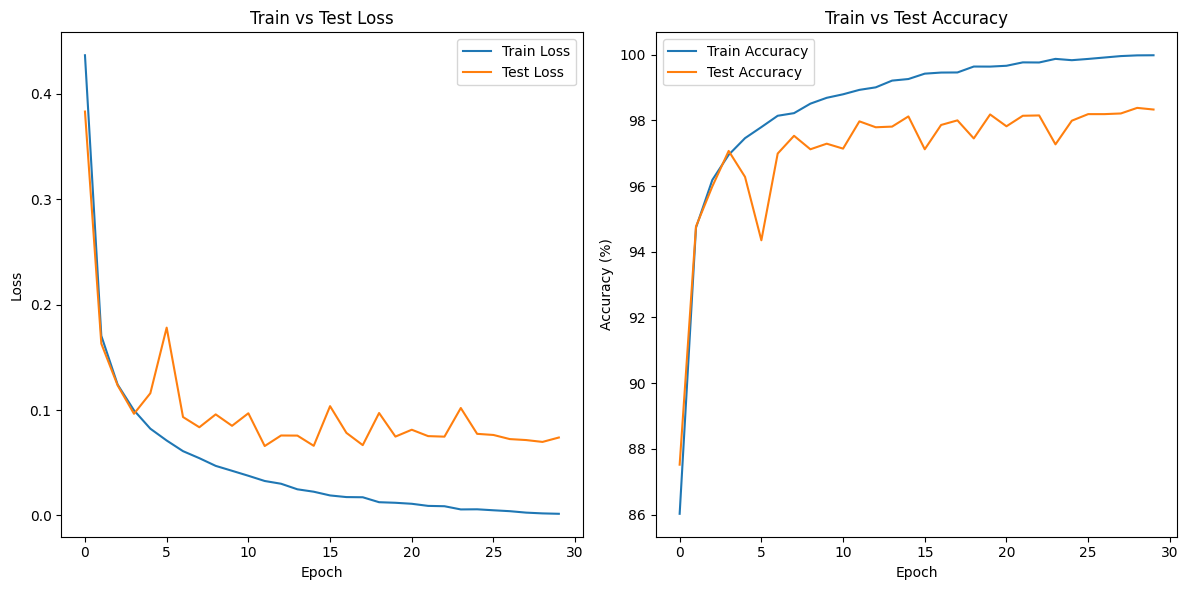

In [ ]:
# 訓練とテストの損失をプロット
plt.figure(figsize=(12, 6))

# 損失のプロット
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# 精度のプロット
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()

# プロットを表示
plt.tight_layout()
plt.show()

左がLossで右が精度です。  
訓練(青)とテスト(オレンジ)を比較するとLossも精度も訓練(青)のほうが良好です。  
この差は過学習によるものです。過学習はモデルが訓練データに適合しすぎる現象です。

## 2. パラメータの数え方

### 2-0.ライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

### 2-1.モデルの定義

前回、線形関数の近似で使った$y=wx+b$を使います。  
この関数で学習可能なパラメータは$w$と$b$の2つです。

In [ ]:
# モデルの定義
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 入力1、出力1の線形層
        init.constant_(self.linear.weight, 0)  # 重みwをすべて0に初期化
        init.constant_(self.linear.bias, 0)    # バイアスbをすべて0に初期化

    def forward(self, x):
        return self.linear(x)

# モデルのインスタンスを作成
model = LinearRegressionModel()

### 2-2. パラメータの数え方

学習可能なパラメータ$w$と$b$はmodel.parameters()によってアクセスできます。

In [ ]:
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


パラメータ数は以下のようにカウントできます。  
numelは"number of elements"(要素数)の略です。

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
num_params

2

### 2-3. nn.Linearのパラメータ数

最後にnn.Linear(入力サイズ, 出力サイズ)のパラメータ数について説明します。  
nn.Linearは(出力サイズ$\times$入力サイズ)の重み行列$\mathbf{W}$と(出力サイズ)のバイアスベクトル$b$を生成します。   
したがって、パラメータ数は  
```
出力サイズ×入力サイズ+出力サイズ  
```
で計算できます。

In [ ]:
# 入力チャンネル数と出力チャンネル数を指定して線形層を作成
input_channels = 5
output_channels = 3
linear_layer = nn.Linear(input_channels, output_channels)

# パラメータ数を計算
num_params = sum(p.numel() for p in linear_layer.parameters())

print(f"nn.Linear({input_channels}, {output_channels}) のパラメータ数: {num_params}")

nn.Linear(5, 3) のパラメータ数: 18


## 3. モデルの軽量化

ChatGPTに代表される大規模言語モデルは大量のパラメータを持っています。  
例えば、Llama 7Bは約70億のパラメータを持ち、32ビット浮動小数点数で保存すると、約28GBのメモリが必要です。  
今回は、モデルの軽量化技術として
- パラメータを低ビットで表現する量子化
- 一部パラメータを0にする枝刈り

について紹介します。

### 3-1. 量子化について

ライブラリのimport

In [ ]:
import torch

今回は4つの要素を持つテンソルを量子化します。

In [ ]:
# 4つの要素を持つ乱数で初期化したテンソルを作成
original_tensor = torch.rand(4)  # 0から1の範囲の一様分布で初期化
print("量子化するテンソル:", original_tensor)

量子化するテンソル: tensor([0.2163, 0.5202, 0.3180, 0.9795])


今回はmin-maxスケーリングと呼ばれる量子化について説明します。  
min-maxスケーリングは最小値と最大値を基に、データを指定した範囲にスケーリングします。  
コードの例は8bit量子化(0~255)を行います。

<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/quant_asym.png" width="50%">

min-maxスケーリングのアルゴリズム
1. 最小値を0にするためにテンソルをminでひく。
1. 0~255の範囲にするためにテンソルに255/(max-min)を乗算する。
1. 整数化する。

In [ ]:
# 最大値と最小値の取得
tensor_max = original_tensor.max()
tensor_min = original_tensor.min()

# 量子化
# テンソルをminでひく
quantized_tensor = original_tensor - tensor_min
# テンソルに255/(max-min)を乗算する
quantized_tensor = quantized_tensor * 255 / (tensor_max-tensor_min)
# 整数化する
quantized_tensor = quantized_tensor.round().clamp(0, 255).int()
print("量子化されたテンソル:", quantized_tensor)

量子化されたテンソル: tensor([  0, 102,  34, 255], dtype=torch.int32)


int32とありますが0から255の範囲です。  
量子化と反対の操作をすることでオリジナルのテンソルに近いテンソルが得られます。

In [ ]:
# 復元
dequantized_tensor = quantized_tensor.float() * (tensor_max-tensor_min) / 255
dequantized_tensor = dequantized_tensor + tensor_min
print("オリジナルのテンソル:", original_tensor)
print("復元されたテンソル:", dequantized_tensor)

オリジナルのテンソル: tensor([0.2163, 0.5202, 0.3180, 0.9795])
復元されたテンソル: tensor([0.2163, 0.5216, 0.3181, 0.9795])


### 3-2. 枝刈りについて

枝刈りは計算への影響が小さい要素を0にする処理です。  
今回は8つの要素を持つテンソルのうち、絶対値が小さい要素を0にする処理を実装します。

<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/pruning.svg" width="50%">

In [ ]:
# 乱数で初期化されたテンソルを作成
tensor = torch.randn(8)
print("オリジナルのテンソル:", tensor)

# プルーニングする個数
num_prune = 2

# num_prune番目に小さい絶対値をスレッショルドに
threshold = torch.topk(tensor.abs(), num_prune, largest=False).values[-1]

# 絶対値が小さい要素をプルーニング
pruned_tensor = tensor.clone()
pruned_tensor[torch.abs(pruned_tensor) <= threshold] = 0

print("プルーニングされたテンソル:", pruned_tensor)

オリジナルのテンソル: tensor([-0.1099,  0.8119, -1.8343, -0.2699, -1.3278, -0.4153,  1.1319, -0.0302])
tensor([ 0.0000,  0.8119, -1.8343, -0.2699, -1.3278, -0.4153,  1.1319,  0.0000])


## 4. オートエンコーダについて

オートエンコーダは入力されたものを出力するように訓練したニューラルネットワークです。  
オートエンコーダは情報を圧縮する「エンコーダ」と圧縮された情報を復元する「デコーダ」からなります。  
今回はオートエンコーダを使って2つの画像の中間画像を生成する処理を実装します。

<img src="https://raw.githubusercontent.com/ArtIC-TITECH/b3-proj-2024/refs/heads/main/resources/class_01/chainer_sda_pic2.jpg" width="50%">

### 4-0.ライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### 4-1.データセットの作成

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 28x28画像をベクトルに変換
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### 4-2.モデルの作成

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # 画像サイズ28x28を128次元に圧縮
            nn.ReLU(),
            nn.Linear(128, 64),       # さらに64次元に圧縮
            nn.ReLU(),
            nn.Linear(64, 32)         # 潜在空間32次元
        )

        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),        # 潜在空間から64次元へ
            nn.ReLU(),
            nn.Linear(64, 128),       # 128次元に拡張
            nn.ReLU(),
            nn.Linear(128, 28 * 28),  # 元の画像サイズ28x28に復元
            nn.Sigmoid()              # 出力を0-1に正規化
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = Autoencoder()

###4-3. 損失関数, 最適化関数の定義

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 4-4. モデルの学習

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.0484
Epoch [2/10], Loss: 0.0264
Epoch [3/10], Loss: 0.0207
Epoch [4/10], Loss: 0.0177
Epoch [5/10], Loss: 0.0156
Epoch [6/10], Loss: 0.0142
Epoch [7/10], Loss: 0.0132
Epoch [8/10], Loss: 0.0124
Epoch [9/10], Loss: 0.0117
Epoch [10/10], Loss: 0.0112


### 4-5. 中間画像の生成

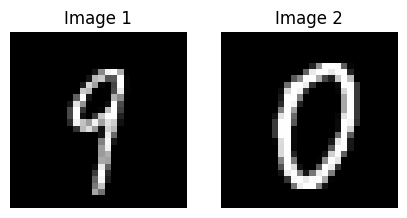

In [ ]:
# サンプルの手書き数字画像を2つ選びます（インデックスを指定）
index1, index2 = 900, 1000
img1, _ = train_dataset[index1]
img2, _ = train_dataset[index2]

# 画像を表示する
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].imshow(img1.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image 1')

axes[1].imshow(img2.view(28, 28), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Image 2')

plt.show()

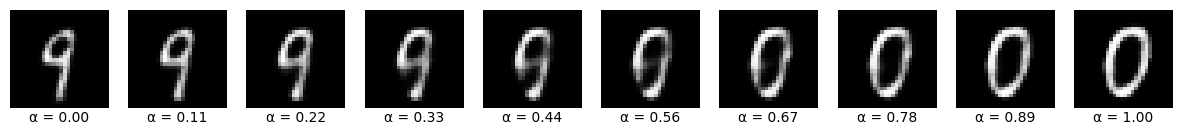

In [ ]:
# 画像をベクトルに変換
img1 = img1.view(1, -1)
img2 = img2.view(1, -1)

# 潜在空間へのエンコード
z1 = model.encoder(img1)
z2 = model.encoder(img2)

# 0〜1の範囲で内挿
num_interpolations = 10
interpolated_images = []
alphas = np.linspace(0, 1, num_interpolations)

fig, axes = plt.subplots(1, num_interpolations, figsize=(15, 5))
for i, ax in enumerate(axes):
    z_interpolated = (1 - alphas[i]) * z1 + alphas[i] * z2
    img_interpolated = model.decoder(z_interpolated).view(28, 28).cpu().detach().numpy()
    ax.imshow(img_interpolated, cmap='gray')
    ax.axis('off')

    # alphaの値を画像の下に表示
    ax.text(0.5, -0.1, f'α = {alphas[i]:.2f}', ha='center', va='center', transform=ax.transAxes)

plt.show()

## 5. テーマの割り当て

テーマA：最適化関数におけるMomentumの評価  
テーマB：学習率とバッチサイズの精度への影響評価  
テーマC：枝刈りによるモデルの性能低下の評価  
テーマD：量子化パラメータのモデル性能への影響  
テーマE：オートエンコーダによる画像のデノイジング  
テーマF：モデルの敵対的サンプルへの耐性評価  
テーマG：オートエンコーダを使った異常検知の分析  
テーマH：リプレイメモリによるモデルの忘却防止評価  